In [1]:
import argparse
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [2]:
def load_data(file_path):
    """
    Load the enriched data with weather and additional features.
    Modify this part based on your actual data structure.
    """
    df = pd.read_csv(file_path)
    # 假设 arrival_minutes_after_noon 是目标变量
    drop_cols = ['Date', 'Week Day', 'Arrival Time']
    df = df.drop(columns=drop_cols, errors='ignore')
    df = df.ffill().bfill()  # 填充缺失值
    return df

In [3]:
def get_features_and_target(df):
    """
    将DataFrame分为特征X和目标y。
    假设 'arrival_minutes_after_noon' 是目标列。
    """
    y = df['arrival_minutes_after_noon']
    X = df.drop(columns=['arrival_minutes_after_noon'])
    return X, y

In [4]:
def plot_actual_vs_predicted(y_actual, y_predicted, title="Actual vs Predicted"):
    """
    绘制实际值和预测值的对比图。
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_predicted, c='red', label='Predictions', alpha=0.6)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()],
             color='blue', linestyle='--', label='Ideal Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
def train_random_forest(X, y):
    """
    使用GridSearchCV对随机森林进行参数搜索和训练。
    """
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ])
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print("Best Parameters for RandomForest:", grid_search.best_params_)
    y_pred = best_model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    print(f"RandomForest MAE on entire set: {mae:.2f}")
    return best_model, y_pred, mae

In [6]:
def train_xgboost(X, y):
    """
    使用GridSearchCV对XGBoost进行参数搜索和训练。
    """
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.1, 0.05],
        'model__gamma': [0, 1]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='mae'))
    ])
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print("Best Parameters for XGBoost:", grid_search.best_params_)
    y_pred = best_model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    print(f"XGBoost MAE on entire set: {mae:.2f}")
    return best_model, y_pred, mae

Training RandomForest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters for RandomForest: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
RandomForest MAE on entire set: 0.21


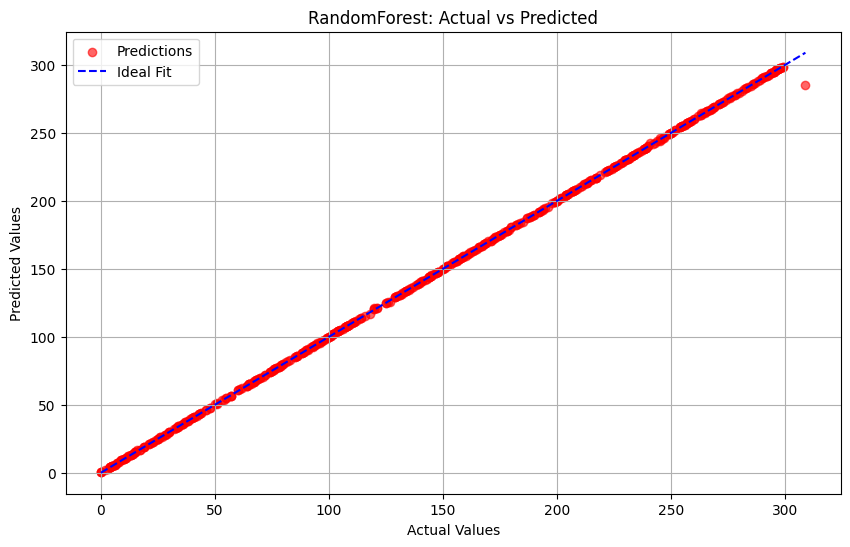

Training completed.


In [8]:
if __name__ == "__main__":
    # 直接赋值代替 argparse
    model_type = 'rf'  # 选择 'rf' 或 'xgb'
    file_path = 'bus_arrival_schedule_with_weather.csv'

    df = load_data(file_path)
    X, y = get_features_and_target(df)

    if model_type.lower() == 'rf':
        print("Training RandomForest...")
        model, y_pred, mae = train_random_forest(X, y)
        plot_actual_vs_predicted(y, y_pred, title="RandomForest: Actual vs Predicted")
    elif model_type.lower() == 'xgb':
        print("Training XGBoost...")
        model, y_pred, mae = train_xgboost(X, y)
        plot_actual_vs_predicted(y, y_pred, title="XGBoost: Actual vs Predicted")
    else:
        print("Invalid model selected. Choose 'rf' or 'xgb'.")
        exit(1)

    print("Training completed.")